# Explore Multiome Data

This is the data exploration notebook for the multimodal data from the Neurips 2021 Multimodal Data Integration Challenge. You can find full documentation for the competition at https://openproblems.bio/neurips_docs/

The goal for this notebook is to introduce you to the multiome gene expression (GEX) and Assay for Transposase-Accessible Chromatin (ATAC) datasets. 

## Loading the data

In [17]:
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from huggingface_hub import hf_hub_download

The data is stored in two AnnData objects, one for each modality. Full documentation for AnnData is [here](https://anndata.readthedocs.io/en/latest/). 

Let's load the multiome data.

In [18]:
REPO_ID = "paupaiz/Bone_Marrow_BMMCs"
gex = "multiome_gex_processed_training.h5ad"
atac = "multiome_atac_processed_training.h5ad"

adata_gex = ad.read_h5ad(
    hf_hub_download(repo_id=REPO_ID, filename=gex, repo_type="dataset"))
adata_gex

AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [19]:
adata_atac = ad.read_h5ad(
    hf_hub_download(repo_id=REPO_ID, filename=atac, repo_type="dataset"))
adata_atac

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

### What is the data?

Data in AnnData object is stored in `adata.X`. The shape of the data is accessible using `adata.shape` or `adata.[n_obs|n_vars]`

In [20]:
print(f"The GEX data has {adata_gex.n_obs} observations and {adata_gex.n_vars} features.")
print(f"The ATAC data has {adata_atac.n_obs} observations and {adata_atac.n_vars} features.")

The GEX data has 42492 observations and 13431 features.
The ATAC data has 42492 observations and 116490 features.


As we can see, there are many more features in the ATAC matrix than in the GEX matrix. This is expected, because ATAC measures accessibility over the entire genome, while GEX only measures expression for the 25,000 genes in the genome. This data has already been preprocessed, so peaks found in fewer than 15 cells and genes detected in fewer than 20 cells were excluded.

### Preprocessing of gene expression

In this dataset, gene expression was measured using 3' capture of nuclear RNA as described in the [10X Multiome Product Guide](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression). Note, not all RNA is found in the nucleus. Comparisons of nuclear and cytosolic RNA have been previously reported (e.g. [Bakken 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209648); [Abdelmoez 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1446-9)) as have comparisons of single-nucleus and single-cell RNA sequencing ([Lake 2017](https://www.nature.com/articles/s41598-017-04426-w)).

For gene expression data, cells were filtered based on mitochondrial content, UMI counts per cell, and genes detected per cell. Size factors were then calculated using [scran](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7) and stored in `adata.obs["size_factors"]`. 

Counts were then normalized per cell by divided the UMI counts by the size factors. Original counts are stored in `adata.layers["counts"]`. The size factor normalized counts are stored in `adata.X`.

Finally, normalized counts are [log1p transformed](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html). These normalized counts are stores in `adata.layers["log_norm"]`.

More information about best practices for single-cell analysis can be found [here](https://www.embopress.org/doi/full/10.15252/msb.20188746).


### Preprocessing of ATAC

The chromatin accessibility data acquired by ATAC-seq as part of the 10X Multiome protocol was processed using [Signac](https://satijalab.org/signac/). Quality control, dimensionality reduction and translating peaks to gene activity scores was performed using Signac, following the authors' instructions. After loading the peak-by-cell matrix, counts were binarized to only represent an accessible versus non-accessible state of each region. Cells were then filtered based on 5 quality control metrics comprising the total number of fragments, the enrichment of fragments detected at transcription start sites (TSS), the fraction of fragments in peak regions compared to peak-flanking regions, the fraction of peaks blacklisted by the ENCODE consortium, and the nucleosome signal, which describes the length distribution of fragments which is expected to follow the length of DNA required span across one nucleosome or multiples of it.

Since ATAC data is sparser than gene expression data, peaks were included if they were accessible in at least 15 cells.

Finally, the data was binarized by setting all values `>0` to `1`. Raw UMI counts for each peak can be found in `adata.layers["counts"]`.

### Feature metadata

More information about the features are available in the `.var` DataFrame of each object. 

#### GEX feature metadata

The GEX `adata.var` DataFrames have the following columns:

* `.var.index` - [Ensembl Gene Names](https://m.ensembl.org/info/genome/genebuild/gene_names.html) for each gene
* `.var["gene_ids"]` - [Ensembl Stable IDs](https://useast.ensembl.org/info/genome/stable_ids/index.html) used to uniquely track genes whose Gene Names may change over time.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `GEX` for all genes
* `.var["genome"]` - The [Genome Assembly](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/) used for read mapping.


In [21]:
adata_gex.var

gene_ids feature_types  genome
AL627309.5  ENSG00000241860           GEX  GRCh38
LINC01409   ENSG00000237491           GEX  GRCh38
LINC01128   ENSG00000228794           GEX  GRCh38
NOC2L       ENSG00000188976           GEX  GRCh38
KLHL17      ENSG00000187961           GEX  GRCh38
...                     ...           ...     ...
MT-ND5      ENSG00000198786           GEX  GRCh38
MT-ND6      ENSG00000198695           GEX  GRCh38
MT-CYB      ENSG00000198727           GEX  GRCh38
AL592183.1  ENSG00000273748           GEX  GRCh38
AC240274.1  ENSG00000271254           GEX  GRCh38

[13431 rows x 3 columns]

#### ATAC feature metadata

The ATAC `adata.var` DataFrames have the following columns:

* `.var.index` - [Genomic coordinates](https://www.idtdna.com/pages/support/faqs/how-are-genomic-coordinates-defined) for each [ATAC peak](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3) that are directly related to the reference genome, and include the chromosome name*, start position, and end position in the following format: `chr1-1234570-1234870`.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `ATAC` for all peaks

*For the curious, chromosome names like `KI270726.1` represent scaffold that are either unlocalized or unplaced (see [Genome Assemblies from Ensembl](https://grch37.ensembl.org/info/genome/genebuild/assembly.html))

In [67]:
adata_atac.var

feature_types
chr1-9776-10668                  ATAC
chr1-180726-181005               ATAC
chr1-181117-181803               ATAC
chr1-191133-192055               ATAC
chr1-267562-268456               ATAC
...                               ...
GL000219.1-90062-90937           ATAC
GL000219.1-99257-100160          ATAC
KI270726.1-27152-28034           ATAC
KI270713.1-21434-22336           ATAC
KI270713.1-29629-30491           ATAC

[116490 rows x 1 columns]

### Observation metadata

There is also information about the observations in the `.obs` DataFrame of each AnnData object.

#### Gene expression observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_genes_by_counts"]` - The number of genes with at least 1 count in a cell. 
* `.obs["pct_counts_mt"]` - Percent of UMI counts mapped to mitochondrial genes. 
* `.obs["n_counts"]` - Number of UMIs detected in the cell
* `.obs["n_genes"]` - Number of genes detected in the cell
* `.obs["size_factors"]` - The estimated size factor for the cell. See [OSCA Ch. 7 - Normalization](https://bioconductor.org/books/release/OSCA/normalization.html)
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["leiden_final"]` -  Cell type annotation based on the `feature_type` of the adata object
* `.obs["atac_ann"]` - The cell type annotation of the cell from the joint ATAC data
* `.obs["cell_type"]` - The cell type annotation of the cells from the GEX data
* `.obs["pseudotime_order_GEX"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult [scanpy.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html)

In [22]:
adata_gex.obs

pct_counts_mt  n_counts  n_genes  size_factors  \
TAGTTGTCACCCTCAC-1-s1d1        1.061008    1508.0   1022.0      0.453484   
CTATGGCCATAACGGG-1-s1d1        0.604230    1655.0   1081.0      0.455631   
CCGCACACAGGTTAAA-1-s1d1        0.650069    7230.0   3304.0      2.435348   
TCATTTGGTAATGGAA-1-s1d1        0.812274    1108.0    793.0      0.347226   
ACCACATAGGTGTCCA-1-s1d1        1.674770    1851.0   1219.0      0.534205   
...                                 ...       ...      ...           ...   
ATTCACTTCCTGCGAA-14-s3d7       0.000000    1475.0    967.0      0.636243   
GCTCTGTTCTGCAAGT-14-s3d7       0.014362    6963.0   3237.0      3.019859   
GCTGAGGAGTGAGCGG-14-s3d7       0.068399    1462.0    876.0      0.495807   
TACTGAGGTTCGCTCA-14-s3d7       0.000000    2808.0   1584.0      1.125766   
CAATAAGCAGATAGAC-14-s3d7       0.000000    1488.0    970.0      0.636224   

                         phase      cell_type  pseudotime_order_GEX batch  \
TAGTTGTCACCCTCAC-1-s1d1      S  Naive CD20+ B                   NaN  s1d1   
CTATGGCCATAACGGG-1-s1d1    G2M     CD14+ Mono                   NaN  s1d1   
CCGCACACAGGTTAAA-1-s1d1    G2M         CD8+ T                   NaN  s1d1   
TCATTTGGTAATGGAA-1-s1d1    G2M         CD8+ T                   NaN  s1d1   
ACCACATAGGTGTCCA-1-s1d1    G2M     CD16+ Mono                   NaN  s1d1   
...                        ...            ...                   ...   ...   
ATTCACTTCCTGCGAA-14-s3d7   G2M         CD8+ T                   NaN  s3d7   
GCTCTGTTCTGCAAGT-14-s3d7     S       G/M prog                   NaN  s3d7   
GCTGAGGAGTGAGCGG-14-s3d7   G2M   Erythroblast              0.791014  s3d7   
TACTGAGGTTCGCTCA-14-s3d7   G2M     CD14+ Mono                   NaN  s3d7   
CAATAAGCAGATAGAC-14-s3d7     S   CD4+ T naive                   NaN  s3d7   

                          pseudotime_order_ATAC  is_train  
TAGTTGTCACCCTCAC-1-s1d1                     NaN      True  
CTATGGCCATAACGGG-1-s1d1                     NaN      True  
CCGCACACAGGTTAAA-1-s1d1                     NaN      True  
TCATTTGGTAATGGAA-1-s1d1                     NaN      True  
ACCACATAGGTGTCCA-1-s1d1                     NaN      True  
...                                         ...       ...  
ATTCACTTCCTGCGAA-14-s3d7                    NaN      True  
GCTCTGTTCTGCAAGT-14-s3d7                    NaN      True  
GCTGAGGAGTGAGCGG-14-s3d7               0.828536      True  
TACTGAGGTTCGCTCA-14-s3d7                    NaN      True  
CAATAAGCAGATAGAC-14-s3d7                    NaN      True  

[42492 rows x 10 columns]

#### ATAC observation metadata

The ATAC `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["nCount_peaks"]` - The number of peaks detected in the cell.
* `.obs["atac_fragments"]` - Number of UMI counts in the cell (both in and not in peaks)
* `.obs["reads_in_peaks_frac"]` - Fraction of UMIs in peaks
* `.obs["blacklist_fraction"]` - Fraction of UMIs in [Encode Blacklisted](https://www.nature.com/articles/s41598-019-45839-z) regions
* `.obs["nucleosome_signal"]` - The [nucleosome signal](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#Sec17), which describes the length distribution of fragments which is expected to follow the length of DNA required span across one nucleosome or multiples of it
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["leiden_final"]` -  Cell type annotation based on the `feature_type` of the adata object
* `.obs["rna_ann"]` - The cell type annotation of the cell from the joint RNA data
* `.obs["cell_type"]` - The cell type annotation of the cells from the ATAC data
* `.obs["pseudotime_order_ATAC"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult the [Signac documentation](https://satijalab.org/signac/)

In [7]:
adata_atac.obs

nCount_peaks  atac_fragments  reads_in_peaks_frac  \
AAACAGCCAACACTTG-2-s1d2        6421.0            8963             0.716390   
AAACAGCCAATAGTCT-s2d4          3232.0            2637             1.225635   
AAACAGCCAATTAAGG-1-s1d1        4624.0            6558             0.705093   
AAACAGCCACCAGGTT-2-s1d2        7177.0            9577             0.749400   
AAACAGCCAGCTACGT-s2d4          5269.0            4573             1.152198   
...                               ...             ...                  ...   
TTTGTTGGTGTAATAC-s2d4           905.0             891             1.015713   
TTTGTTGGTTAGACCA-2-s1d2        6669.0            8699             0.766640   
TTTGTTGGTTCGGTAA-1-s1d1        7074.0            9873             0.716500   
TTTGTTGGTTTGGGTA-4-s2d1        8404.0           13557             0.619901   
TTTGTTGGTTTGGTTC-s2d4          1437.0            1256             1.144108   

                         blacklist_fraction  nucleosome_signal      cell_type  \
AAACAGCCAACACTTG-2-s1d2            0.000623           0.832734             NK   
AAACAGCCAATAGTCT-s2d4              0.000000           0.888535  Naive CD20+ B   
AAACAGCCAATTAAGG-1-s1d1            0.001730           0.688525   CD4+ T naive   
AAACAGCCACCAGGTT-2-s1d2            0.000557           0.772973             NK   
AAACAGCCAGCTACGT-s2d4              0.000380           0.846552         CD8+ T   
...                                     ...                ...            ...   
TTTGTTGGTGTAATAC-s2d4              0.000000           1.080808   Erythroblast   
TTTGTTGGTTAGACCA-2-s1d2            0.001799           0.639382         CD8+ T   
TTTGTTGGTTCGGTAA-1-s1d1            0.001414           0.868516             NK   
TTTGTTGGTTTGGGTA-4-s2d1            0.000952           1.495506   CD4+ T naive   
TTTGTTGGTTTGGTTC-s2d4              0.001392           1.185714           cDC2   

                         pseudotime_order_ATAC batch  
AAACAGCCAACACTTG-2-s1d2                    NaN  s1d2  
AAACAGCCAATAGTCT-s2d4                      NaN  s2d4  
AAACAGCCAATTAAGG-1-s1d1                    NaN  s1d1  
AAACAGCCACCAGGTT-2-s1d2                    NaN  s1d2  
AAACAGCCAGCTACGT-s2d4                      NaN  s2d4  
...                                        ...   ...  
TTTGTTGGTGTAATAC-s2d4                 0.697933  s2d4  
TTTGTTGGTTAGACCA-2-s1d2                    NaN  s1d2  
TTTGTTGGTTCGGTAA-1-s1d1                    NaN  s1d1  
TTTGTTGGTTTGGGTA-4-s2d1                    NaN  s2d1  
TTTGTTGGTTTGGTTC-s2d4                      NaN  s2d4  

[20952 rows x 8 columns]

## Visualizing the data using UMAP

The exploratory datasets have already been preprocessed and prepared for visualization using [UMAP](https://umap-learn.readthedocs.io/en/latest/).

#### Visualizing Gene Expression

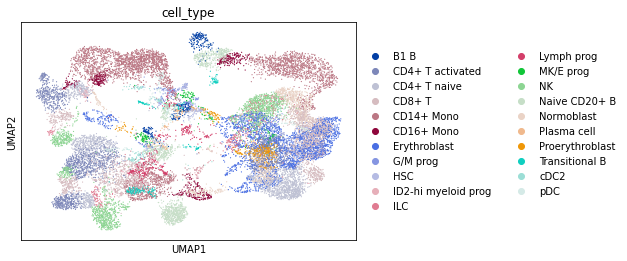

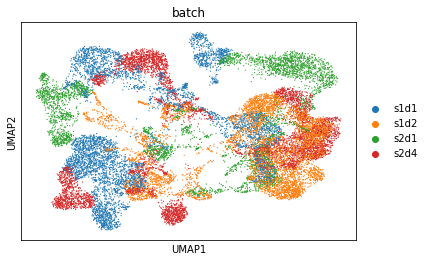

In [8]:
sc.pl.umap(adata_gex, color='cell_type')
sc.pl.umap(adata_gex, color='batch')

Note, for the `.obs["batch"]` metadata, the symbol represents the site and donor in the following format: `s1d1` for site 1, donor 1.

#### Visualizing ATAC

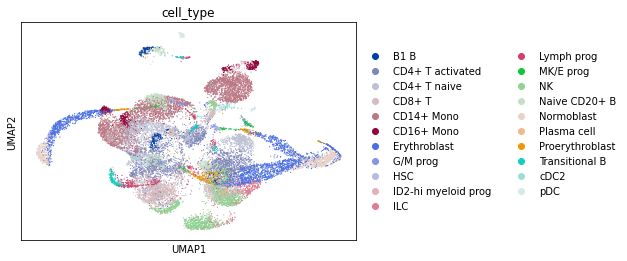

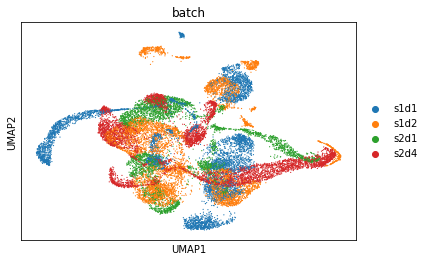

In [9]:
sc.pl.umap(adata_atac, color='cell_type')
sc.pl.umap(adata_atac, color='batch')

## Simple modality prediction

Task 1 of the competition was Modality Prediction. A full description of the task is available on the [Task Documentation](https://openproblems.bio/neurips_docs/about_tasks/task1_modality_prediction/).

Simply put, the goal was to take one modality as input and predict the other. Methods are given some training data in which modality 1 and modality 2 are known, and then a set of cells where only modality 1 is provided.

You can make your own train / validation split in this notebook:

### Creating test / validation split

Let's start by using `s2d4` as our hold out sample.

In [23]:
train_cells = adata_gex.obs_names[adata_gex.obs["batch"] != "s2d4"]
test_cells  = adata_gex.obs_names[adata_gex.obs["batch"] == "s2d4"]

As we can see from the Task 1 documentation, methods for task one should expect the following input:
* `input_train_mod1`
* `input_train_mod2`
* `input_test_mod1`

Metrics then expect as input:
* `true_test_mod2`
* `pred_test_mod2`

With that, let's subset our data into these expected objects focusing on the subtask of predicting GEX from ATAC. 

In [24]:
# This will get passed to the method
input_train_mod1 = adata_atac[train_cells]
input_train_mod2 = adata_gex[train_cells]
input_test_mod1 =  adata_atac[test_cells]

# This will get passed to the metric
true_test_mod2 =  adata_gex[test_cells]

### RMSE Metric

The metric for task 1 is RMSE on the `adata.layers["log_norm"]` data.

In [25]:
def calculate_rmse(true_test_mod2, pred_test_mod2):
    if pred_test_mod2.var["feature_types"][0] == "GEX":
        return  mean_squared_error(true_test_mod2.layers["log_norm"].toarray(), pred_test_mod2.X, squared=False)
    else:
        raise NotImplementedError("Only set up to calculate RMSE for GEX data")

### Method

Let's try a method that runs linear regression on PCA transformed data before projecting the data back to the feature space.

In [26]:
def baseline_linear(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Baseline method training a linear regressor on the input data'''
    input_mod1 = ad.concat(
        {"train": input_train_mod1, "test": input_test_mod1},
        axis=0,
        join="outer",
        label="group",
        fill_value=0,
        index_unique="-", 
    )
    
    # Binarize ATAC 
    if input_train_mod1.var["feature_types"][0] == "ATAC":
        input_mod1.X[input_mod1.X > 1] = 1
    elif input_train_mod2.var["feature_types"][0] == "ATAC":
        input_train_mod2.X[input_mod1.X > 1] = 1
    
    # Do PCA on the input data
    logging.info('Performing dimensionality reduction on modality 1 values...')
    embedder_mod1 = TruncatedSVD(n_components=50)
    mod1_pca = embedder_mod1.fit_transform(input_mod1.X)
    
    logging.info('Performing dimensionality reduction on modality 2 values...')
    embedder_mod2 = TruncatedSVD(n_components=50)
    mod2_pca = embedder_mod2.fit_transform(input_train_mod2.layers["log_norm"])
    
    # split dimred mod 1 back up for training
    X_train = mod1_pca[input_mod1.obs['group'] == 'train']
    X_test = mod1_pca[input_mod1.obs['group'] == 'test']
    y_train = mod2_pca
    
    assert len(X_train) + len(X_test) == len(mod1_pca)
    
    logging.info('Running Linear regression...')
    
    reg = LinearRegression()
    
    # Train the model on the PCA reduced modality 1 and 2 data
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    # Project the predictions back to the modality 2 feature space
    y_pred = y_pred @ embedder_mod2.components_
    
    pred_test_mod2 = ad.AnnData(
        X = y_pred,
        obs = input_test_mod1.obs,
        var = input_train_mod2.var,
    
    )
    
    # Add the name of the method to the result
    pred_test_mod2.uns["method"] = "linear"
    
    return pred_test_mod2

Now, for comparison, let's create a simple dummy method that simply returns the mean for the input modality 2 data. This method returns an identical prediction for all cells and ignores the modality 1 information altogether.

In [27]:
def baseline_mean(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Dummy method that predicts mean(input_train_mod2) for all cells'''
    logging.info('Calculate mean of the training data modality 2...')
    y_pred = np.repeat(input_train_mod2.layers["log_norm"].mean(axis=0).reshape(-1,1).T, input_test_mod1.shape[0], axis=0)
    
    # Prepare the ouput data object
    pred_test_mod2 = ad.AnnData(
        X=y_pred,
        obs=input_test_mod1.obs,
        var=input_train_mod2.var,
    )
    
    pred_test_mod2.uns["method"] = "mean"

    return pred_test_mod2

#### Run comparison

You can run this simple and dummy method side-by-side and compare how performance is influenced by batch effects. Consult the batch correction literature for strategies to mitigate this technical noise. [Lucken 2021](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2) is a good starting place.

Now the challenge is up to you! Can you do better than this baseline?